In [35]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [36]:
import os
import re
import joblib
import pandas as pd
import spacy
from joblib import Parallel, delayed, parallel_backend
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Imposta i percorsi relativi al project root
BASE_DIR = PROJECT_ROOT
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
TRAINED_DIR = os.path.join(BASE_DIR, 'data', 'trained')

TICKET_O3_PATH = os.path.join(DATA_RAW_DIR, 'ticket-o3.csv')
TICKET_GEMINI_PATH = os.path.join(DATA_RAW_DIR, 'ticket-gemini-claude.csv')
PROCESSED_DATA_PATH = os.path.join(PROCESSED_DIR, 'X_processed.csv')

os.makedirs(DATA_RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(TRAINED_DIR, exist_ok=True)

print('[INFO] Percorso per ticket-o3:', TICKET_O3_PATH)
print('[INFO] Percorso per ticket-gemini:', TICKET_GEMINI_PATH)

[INFO] Percorso per ticket-o3: H:\Informatica\astromark-ai\data\raw\ticket-o3.csv
[INFO] Percorso per ticket-gemini: H:\Informatica\astromark-ai\data\raw\ticket-gemini-claude.csv


In [37]:
# Caricamento e unione dei dati
print('[INFO] Caricamento di ticket-o3...')
dataframe_o3 = pd.read_csv(TICKET_O3_PATH, usecols=['titolo', 'messaggio', 'categoria'])
print(f'[INFO] ticket-o3.csv caricato con shape: {dataframe_o3.shape}')

print('[INFO] Caricamento di ticket-gemini-claude...')
dataframe_gc = pd.read_csv(TICKET_GEMINI_PATH, usecols=['titolo', 'messaggio', 'categoria'])
print(f'[INFO] ticket-gemini-claude.csv caricato con shape: {dataframe_gc.shape}')

def merge_dataframes(frame1, frame2):
    print('[INFO] Unione dei dataframe...')
    frame = pd.concat([frame1, frame2])
    
    num_duplicated = frame.duplicated().sum()
    frame.drop_duplicates(inplace=True)
    print(f'[INFO] Eliminate {num_duplicated} righe duplicate:')
    
    frame['titolo_messaggio'] = frame['titolo'] + ' ' + frame['messaggio']
    return frame[['titolo_messaggio', 'categoria']]

merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
print(f'[INFO] Dataset unito finale: {merged_df.shape}')

[INFO] Caricamento di ticket-o3...
[INFO] ticket-o3.csv caricato con shape: (4662, 3)
[INFO] Caricamento di ticket-gemini-claude...
[INFO] ticket-gemini-claude.csv caricato con shape: (866, 3)
[INFO] Unione dei dataframe...
[INFO] Eliminate 291 righe duplicate:
[INFO] Dataset unito finale: (5237, 2)



Statistiche descrittive per categoria:
categoria
Segreteria    1088
Didattica     1085
Tecnico       1072
Accesso       1007
Profilo        985
dtype: int64

Percentuali per categoria:
categoria
Segreteria    20.78
Didattica     20.72
Tecnico       20.47
Accesso       19.23
Profilo       18.81
Name: proportion, dtype: float64


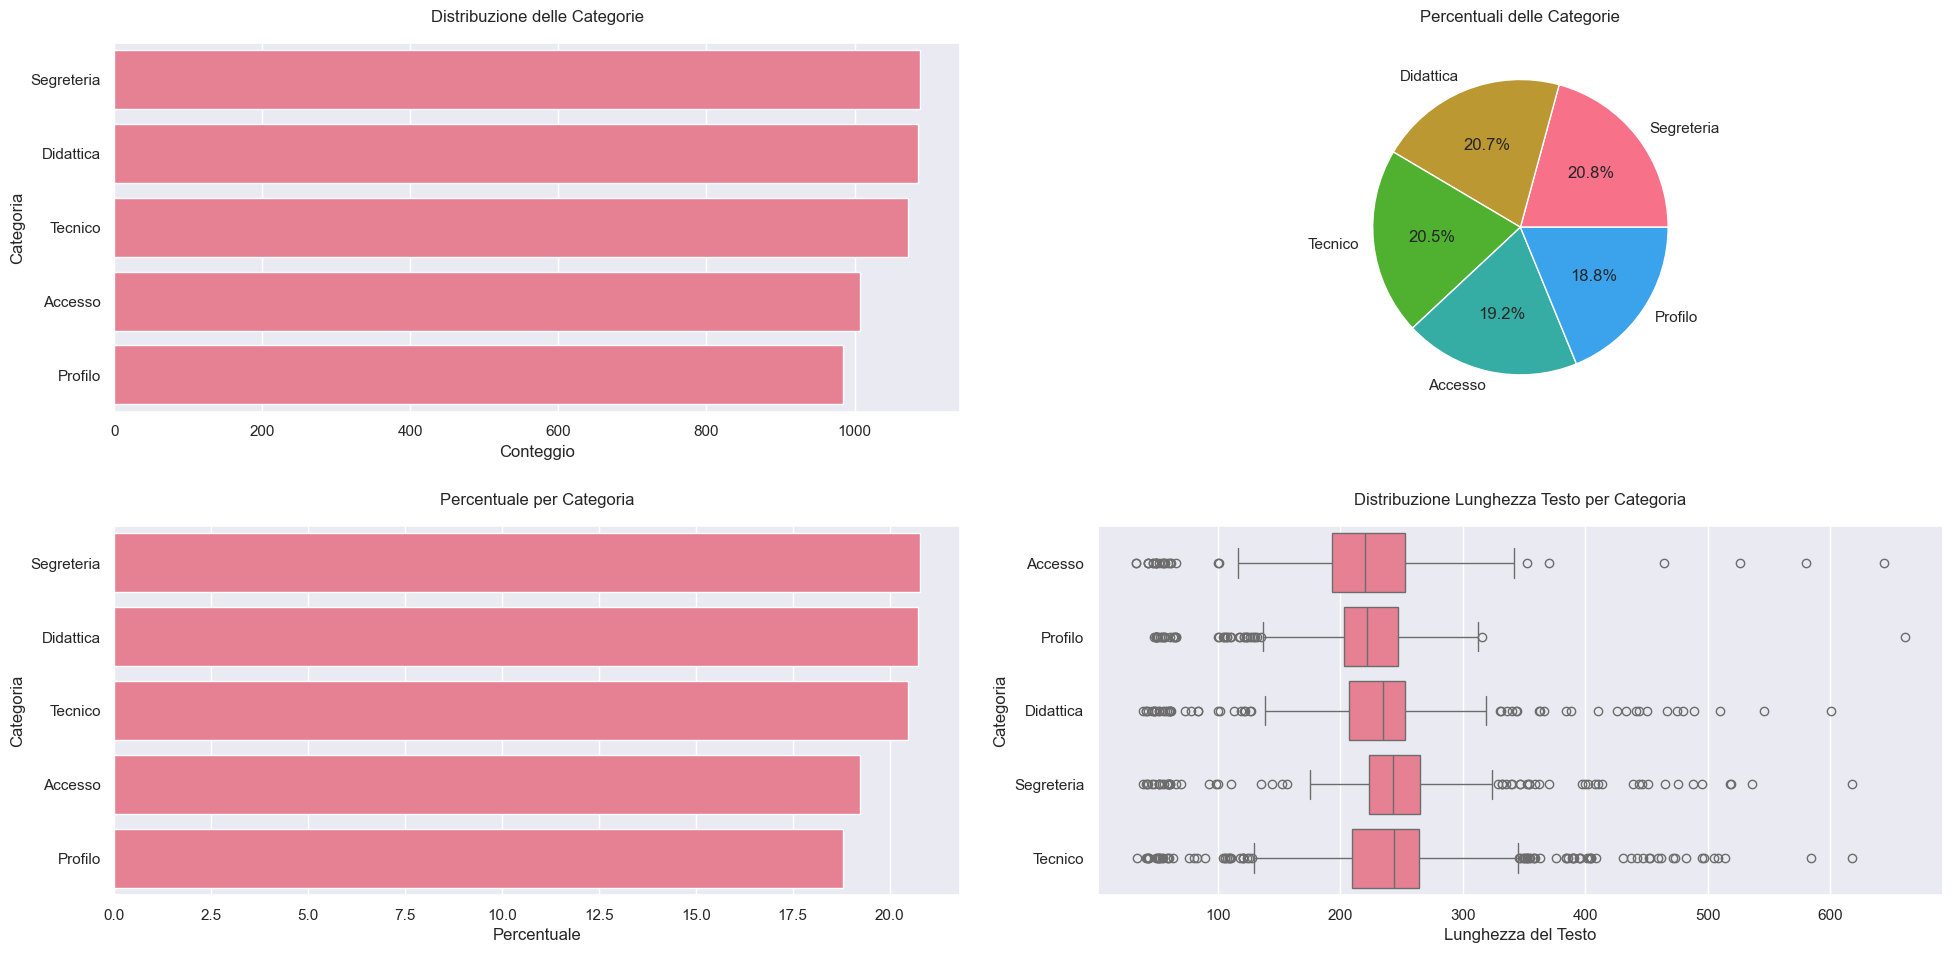

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

In [39]:
# Preprocessing minimo del testo con spaCy
print('[INFO] Caricamento del modello spaCy (it_core_news_sm)...')
nlp = spacy.load('it_core_news_sm')

# Definiamo i saluti da rimuovere
GREETINGS_PATTERNS = [
    r'\bciao\b', r'\bbuongiorno\b', r'\bsalve\b',
    r'\bbuonasera\b', r'\bbuon pomeriggio\b', r'\barrivederci\b',
    r'\bbuonanotte\b', r'\ba presto\b', r'\baddio\b', r'\bsaluti\b'
]

def remove_greetings(text):
    pattern = re.compile('|'.join(GREETINGS_PATTERNS), flags=re.IGNORECASE)
    return pattern.sub('', text)

def minimal_preprocess(text):
    text = text.lower().strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # rimozione URL
    text = remove_greetings(text)
    text = re.sub(r'[^\w\s]', ' ', text)  # rimozione punteggiatura
    text = re.sub(r'\d+', '', text)  # rimozione numeri
    text = re.sub(r'\s+', ' ', text)  # normalizzazione spazi
    return text.strip()

def process_text(text):
    cleaned_text = minimal_preprocess(text)
    doc = nlp(cleaned_text)
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        lemma = token.lemma_
        if lemma:
            lemma = lemma.strip()
            if lemma:
                tokens.append(lemma)
    for ent in doc.ents:
        tokens.append(f"NER_{ent.label_}")
    return ' '.join(tokens)

def parallel_process_texts(series, n_jobs=-1):
    print('[INFO] Preprocessing in parallelo con backend threading...')
    with parallel_backend('threading', n_jobs=n_jobs):
        processed = Parallel()(delayed(process_text)(text) for text in series)
    return pd.Series(processed, index=series.index)

[INFO] Caricamento del modello spaCy (it_core_news_sm)...


In [40]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    print(f"[INFO] Caricamento dei dati preprocessati da '{PROCESSED_DATA_PATH}'...")
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    print('[INFO] Dati preprocessati non trovati, inizio preprocessing in parallelo...')
    X_processed = parallel_process_texts(X, n_jobs=-1)
    print('[INFO] Salvataggio dei dati preprocessati in:', PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    print('[INFO] Preprocessing completato e memorizzato.')

[INFO] Caricamento dei dati preprocessati da 'H:\Informatica\astromark-ai\data\processed\X_processed.csv'...


In [41]:
from service.pipeline import ClassifierType
from sklearn.pipeline import Pipeline


# Funzioni per costruire la pipeline e la Grid Search
def build_pipeline(classifier_type):
    tfidf = TfidfVectorizer(
        use_idf=True,
        ngram_range=(1, 1),
        max_features=2000,
        norm='l2',
        smooth_idf=True,
        sublinear_tf=True
    )

    if classifier_type == ClassifierType.NAIVE_BAYES:
        classifier = MultinomialNB()
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('clf', classifier)
        ])
        param_grid = {
            'tfidf__min_df': [1, 3],
            'tfidf__max_df': [0.85, 0.90],
            'clf__alpha': [1.0, 1.5, 2.0]
        }
    elif classifier_type == ClassifierType.SVM:
        svd = TruncatedSVD(n_components=50, random_state=42)
        classifier = SVC(probability=True, kernel='linear', random_state=42)
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('svd', svd),
            ('clf', classifier)
        ])
        param_grid = {
            'tfidf__min_df': [1, 3],
            'tfidf__max_df': [0.85, 0.90],
            'svd__n_components': [30, 50],
            'clf__C': [0.1, 0.5, 1.0]
        }
    else:
        raise ValueError("Unsupported classifier type.")
    return pipeline, param_grid

def perform_grid_search(X, y, classifier_type):
    print(f"[INFO] Costruisco la pipeline per {classifier_type.value}...")
    pipeline, param_grid = build_pipeline(classifier_type)
    print(f"[INFO] Avvio Grid Search per {classifier_type.value} con parametri: {param_grid}")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    print(f"[INFO] Grid Search per {classifier_type.value} completata.")
    print(f"[INFO] Parametri migliori: {grid.best_params_}")
    return grid.best_estimator_


In [42]:
# Funzioni per salvare/caricare il modello
MODEL_PATHS = {
    "naive_bayes": os.path.join(TRAINED_DIR, "trained_model_nb.pkl"),
    "svm": os.path.join(TRAINED_DIR, "trained_model_svm.pkl")
}

def save_model(model, classifier_type):
    path = MODEL_PATHS[classifier_type.value]
    joblib.dump(model, path)
    print(f"[INFO] Modello salvato in {path}.")

def load_model(classifier_type):
    path = MODEL_PATHS[classifier_type.value]
    if os.path.exists(path):
        print(f"[INFO] Caricamento del modello da {path}...")
        return joblib.load(path)
    return None

def get_model(classifier_type):
    """Se esiste un modello preaddestrato, lo carica; altrimenti esegue la grid search e lo salva."""
    model = load_model(classifier_type)
    if model is None:
        print(f"[INFO] Nessun modello salvato per {classifier_type.value}. Avvio training...")
        model = perform_grid_search(X_processed, y, classifier_type)
        save_model(model, classifier_type)
    else:
        print(f"[INFO] Uso il modello salvato per {classifier_type.value}.")
    return model

## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`.

In [43]:
from service.report_predict import evaluate_model_with_kfold
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    print(evaluate_model_with_kfold(get_model(classifier_type), X_processed, y, save_plots=False))
    print(f"[INFO] Classificatore selezionato: {classifier_type.value}")
    print("[INFO] Recupero del modello finale (lo carico se già esistente)...")
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

## Esempio di utilizzo con SVM

[INFO] Generating full model report...


[INFO] Caricamento del modello da H:\Informatica\astromark-ai\data\trained\trained_model_svm.pkl...
[INFO] Uso il modello salvato per svm.


[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8897
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.928571  0.936646  0.932591   805.000000
Didattica      0.882081  0.879032  0.880554   868.000000
Profilo        0.955729  0.931472  0.943445   788.000000
Segreteria     0.896806  0.838117  0.866469   871.000000
Tecnico        0.802151  0.870478  0.834919   857.000000
accuracy       0.889711  0.889711  0.889711     0.889711
macro avg      0.893068  0.891149  0.891596  4189.000000
weighted avg   0.891578  0.889711  0.890120  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[754   5  12   6  28]
 [  3 763   2  42  58]
 [ 21   2 734  15  16]
 [  1  51   7 730  82]
 [ 33  44  13  21 746]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8931
[INFO] Classification Report (Test):
              precision    recall

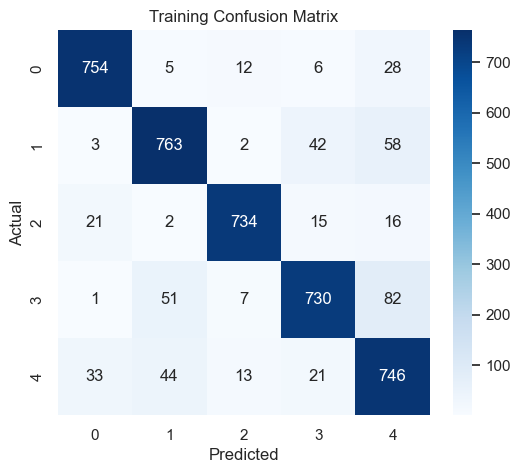

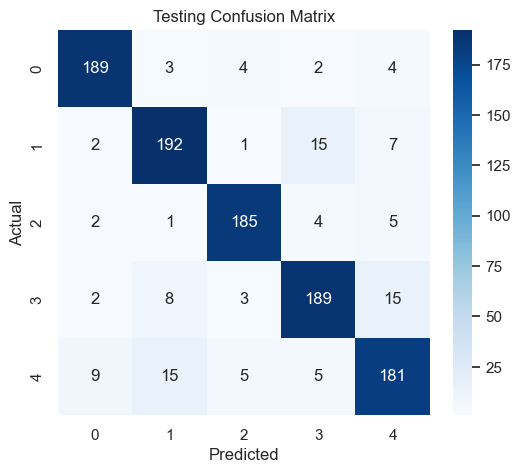

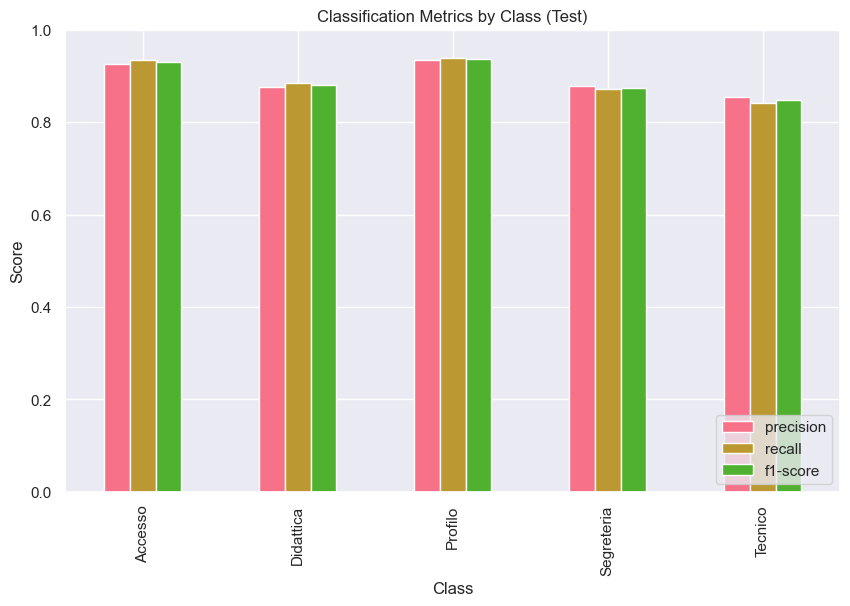

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8864
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.921279  0.930435  0.925834   805.000000
Didattica      0.874710  0.868664  0.871676   868.000000
Profilo        0.945876  0.931472  0.938619   788.000000
Segreteria     0.882423  0.853042  0.867484   871.000000
Tecnico        0.818080  0.855309  0.836281   857.000000
accuracy       0.886369  0.886369  0.886369     0.886369
macro avg      0.888474  0.887784  0.887979  4189.000000
weighted avg   0.887065  0.886369  0.886563  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[749   8  14   8  26]
 [  5 754   3  54  52]
 [ 19   3 734  14  18]
 [  3  48  10 743  67]
 [ 37  49  15  23 733]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9065
[INFO] Classification Report (T

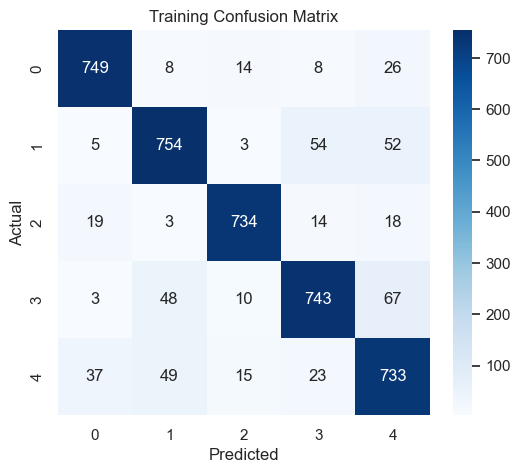

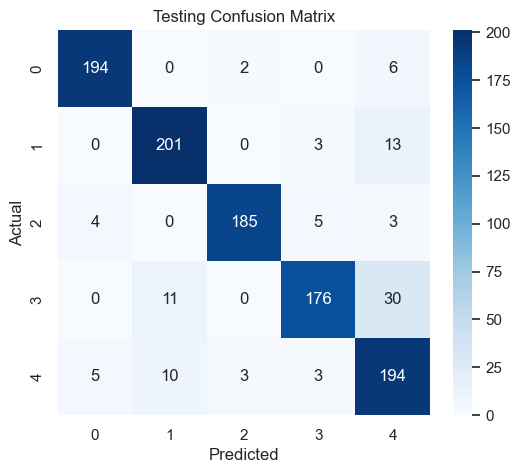

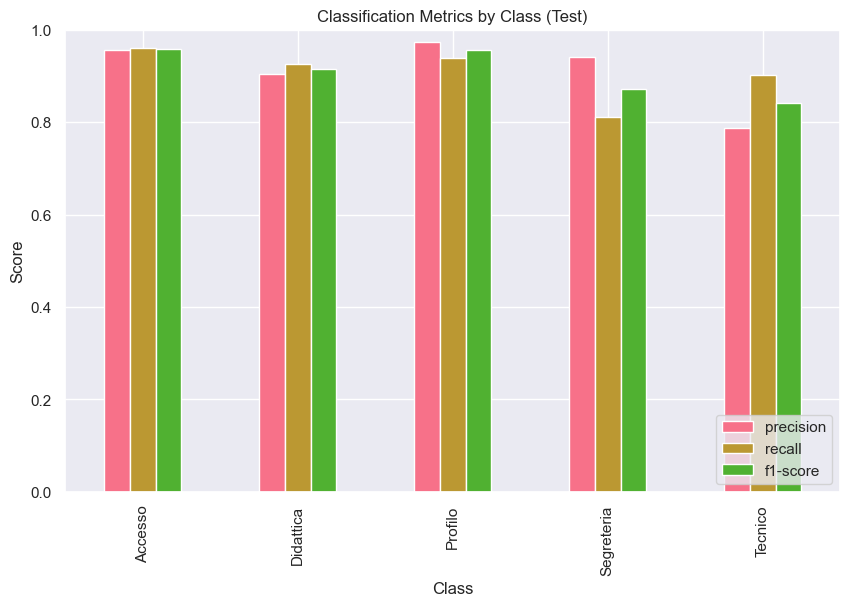

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8945
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.931204  0.940447  0.935802   806.000000
Didattica      0.884703  0.892857  0.888761   868.000000
Profilo        0.954663  0.935279  0.944872   788.000000
Segreteria     0.891435  0.849425  0.869923   870.000000
Tecnico        0.822024  0.861305  0.841207   858.000000
accuracy       0.894511  0.894511  0.894511     0.894511
macro avg      0.896806  0.895863  0.896113  4190.000000
weighted avg   0.895368  0.894511  0.894713  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[758   6  12   7  23]
 [  4 775   2  44  43]
 [ 16   2 737  17  16]
 [  3  44   6 739  78]
 [ 33  49  15  22 739]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8739
[INFO] Classification Report (T

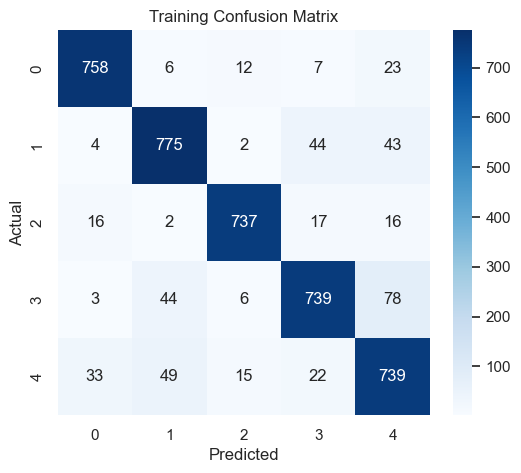

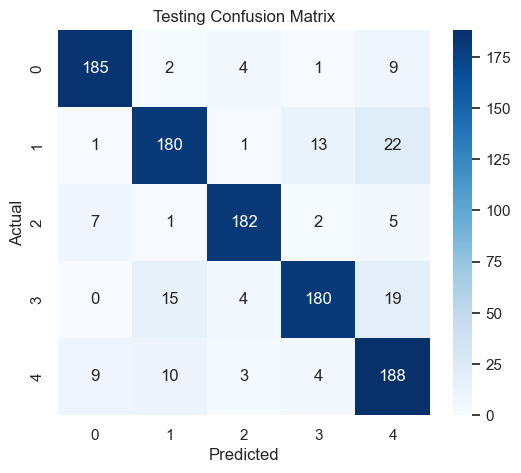

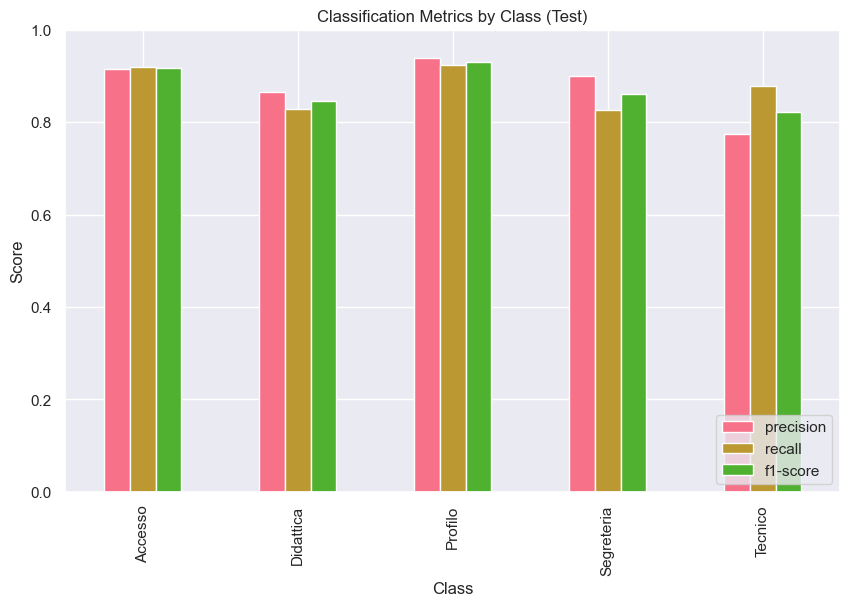

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8912
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.931034  0.937965  0.934487   806.000000
Didattica      0.886946  0.876728  0.881808   868.000000
Profilo        0.954839  0.939086  0.946897   788.000000
Segreteria     0.894737  0.840230  0.866627   870.000000
Tecnico        0.803879  0.869464  0.835386   858.000000
accuracy       0.891169  0.891169  0.891169     0.891169
macro avg      0.894287  0.892695  0.893041  4190.000000
weighted avg   0.892803  0.891169  0.891524  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[756   5  12   5  28]
 [  4 761   2  46  55]
 [ 16   3 740  14  15]
 [  2  45   8 731  84]
 [ 34  44  13  21 746]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8873
[INFO] Classification Report (T

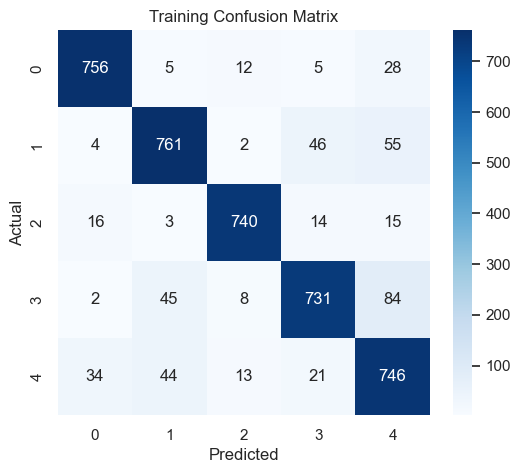

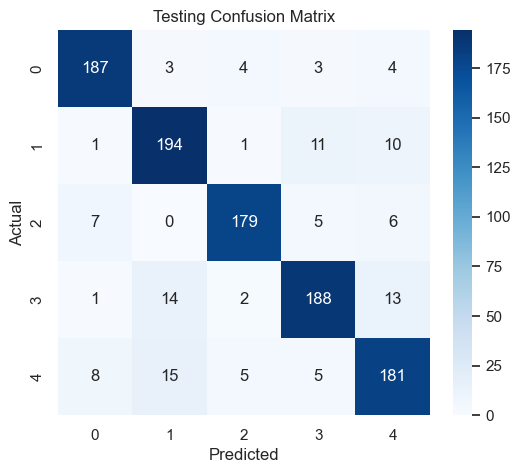

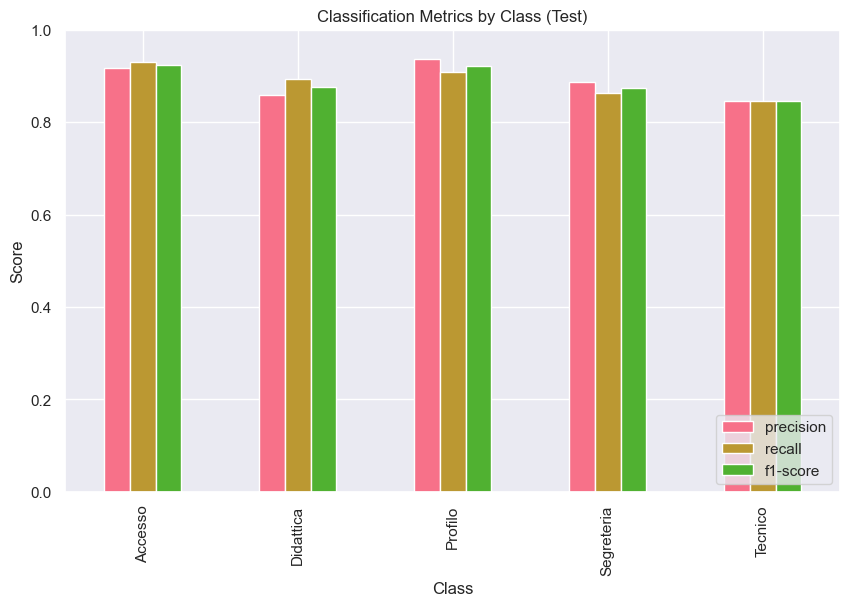

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8902
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.928659  0.936725  0.932674   806.000000
Didattica      0.876571  0.883641  0.880092   868.000000
Profilo        0.945666  0.927665  0.936579   788.000000
Segreteria     0.900491  0.842529  0.870546   870.000000
Tecnico        0.813115  0.867133  0.839255   858.000000
accuracy       0.890215  0.890215  0.890215     0.890215
macro avg      0.892901  0.891538  0.891829  4190.000000
weighted avg   0.891558  0.890215  0.890486  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[755   8  14   6  23]
 [  4 767   3  42  52]
 [ 20   2 731  16  19]
 [  3  48   9 733  77]
 [ 31  50  16  17 744]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8911
[INFO] Classification Report (T

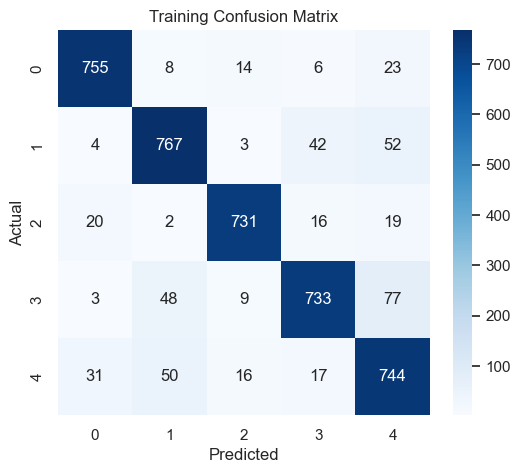

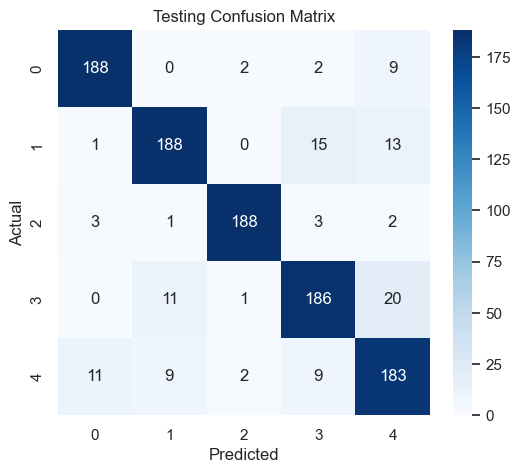

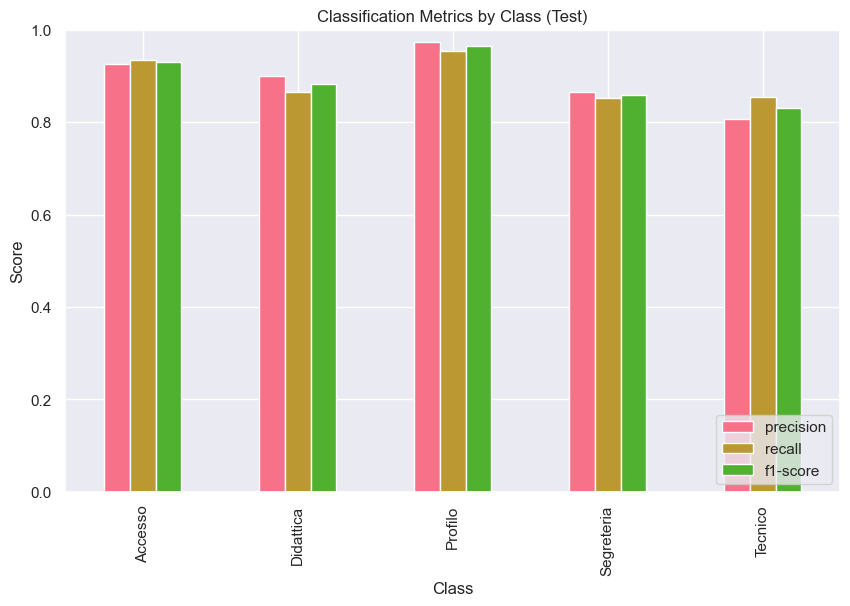

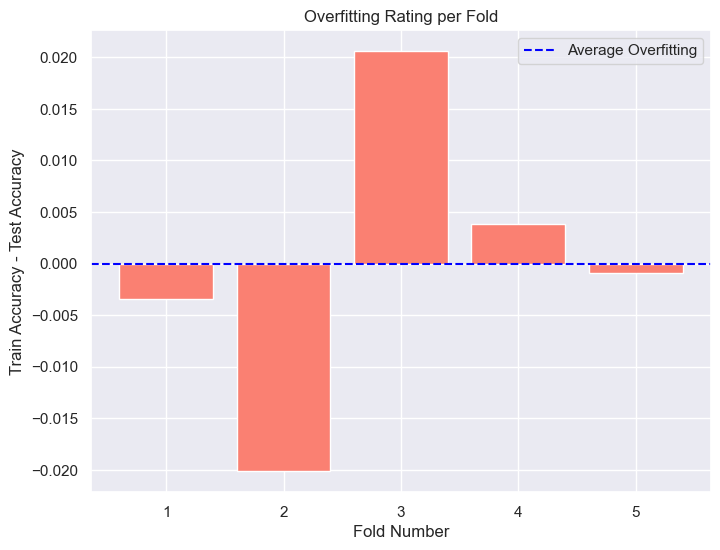

[INFO] Final average evaluation: {'train': {'avg_accuracy': np.float64(0.8903950396281658), 'avg_auc': None, 'avg_confusion_matrix': array([[754.4,   6.4,  12.8,   6.4,  25.6],
       [  4. , 764. ,   2.4,  45.6,  52. ],
       [ 18.4,   2.4, 735.2,  15.2,  16.8],
       [  2.4,  47.2,   8. , 735.2,  77.6],
       [ 33.6,  47.2,  14.4,  20.8, 741.6]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.928150  0.936443  0.932278   805.600000
Didattica      0.881002  0.880184  0.880578   868.000000
Profilo        0.951355  0.932995  0.942082   788.000000
Segreteria     0.893178  0.844669  0.868210   870.400000
Tecnico        0.811850  0.864738  0.837410   857.600000
accuracy       0.890395  0.890395  0.890395     0.890395
macro avg      0.893107  0.891806  0.892112  4189.600000
weighted avg   0.891675  0.890395  0.890681  4189.600000}, 'test': {'avg_accuracy': np.float64(0.8903916679425767), 'avg_auc': None, 'avg_confusion_matrix': arr

{'train': {'avg_accuracy': np.float64(0.8903950396281658), 'avg_auc': None, 'avg_confusion_matrix': array([[754.4,   6.4,  12.8,   6.4,  25.6],
       [  4. , 764. ,   2.4,  45.6,  52. ],
       [ 18.4,   2.4, 735.2,  15.2,  16.8],
       [  2.4,  47.2,   8. , 735.2,  77.6],
       [ 33.6,  47.2,  14.4,  20.8, 741.6]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.928150  0.936443  0.932278   805.600000
Didattica      0.881002  0.880184  0.880578   868.000000
Profilo        0.951355  0.932995  0.942082   788.000000
Segreteria     0.893178  0.844669  0.868210   870.400000
Tecnico        0.811850  0.864738  0.837410   857.600000
accuracy       0.890395  0.890395  0.890395     0.890395
macro avg      0.893107  0.891806  0.892112  4189.600000
weighted avg   0.891675  0.890395  0.890681  4189.600000}, 'test': {'avg_accuracy': np.float64(0.8903916679425767), 'avg_auc': None, 'avg_confusion_matrix': array([[188.6,   1.6,   3.2,   1.6, 

In [44]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
svm_predictions = ticket_service(example_title, example_message, ClassifierType.SVM)

In [45]:
pd.DataFrame(svm_predictions, columns=["Class", "Probability"])

,Class,Probability
0,Tecnico,0.941806
1,Accesso,0.025999
2,Segreteria,0.021202


## Esempio di utilizzo con NAIVE BAYES

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9236
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.951807  0.981366  0.966361   805.000000
Didattica      0.926540  0.900922  0.913551   868.000000
Profilo        0.927607  0.959391  0.943231   788.000000
Segreteria     0.926014  0.890930  0.908133   871.000000
Tecnico        0.887471  0.892649  0.890052   857.000000
accuracy       0.923609  0.923609  0.923609     0.923609
macro avg      0.923888  0.925052  0.924266  4189.000000
weighted avg   0.923494  0.923609  0.923349  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[790   1   8   1   5]
 [  3 782   2  41  40]
 [  7   7 756  12   6]
 [  4  27  18 776  46]
 [ 26  27  31   8 765]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9132
[INFO] Classification Report (T

[INFO] Caricamento del modello da H:\Informatica\astromark-ai\data\trained\trained_model_nb.pkl...
[INFO] Uso il modello salvato per naive_bayes.


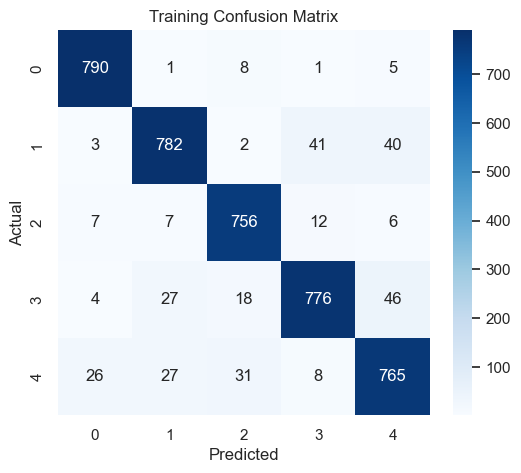

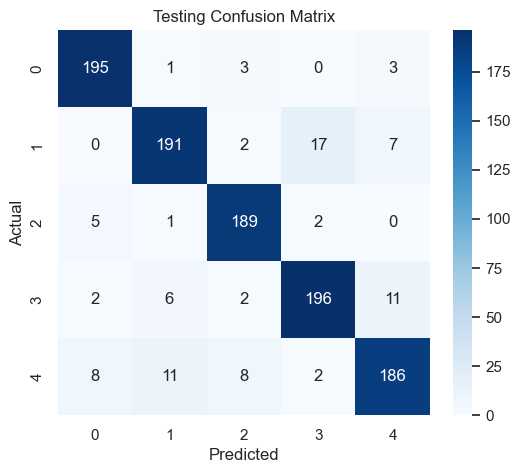

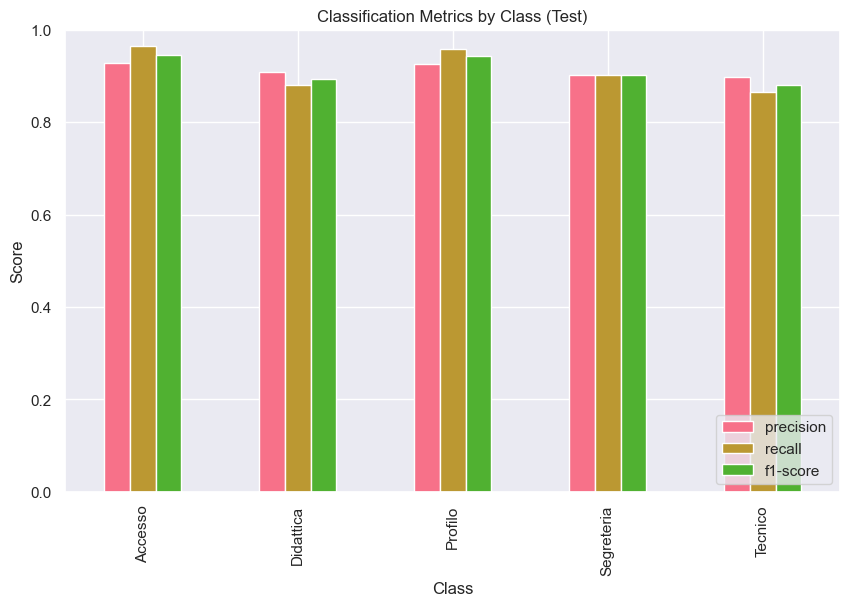

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9205
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.942446  0.976398  0.959121   805.000000
Didattica      0.920897  0.898618  0.909621   868.000000
Profilo        0.923077  0.959391  0.940884   788.000000
Segreteria     0.916569  0.895522  0.905923   871.000000
Tecnico        0.899761  0.879813  0.889676   857.000000
accuracy       0.920506  0.920506  0.920506     0.920506
macro avg      0.920550  0.921948  0.921045  4189.000000
weighted avg   0.920224  0.920506  0.920165  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[786   2  10   1   6]
 [  2 780   4  51  31]
 [ 12   5 756  10   5]
 [  5  28  16 780  42]
 [ 29  32  33   9 754]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9256
[INFO] Classification Report (T

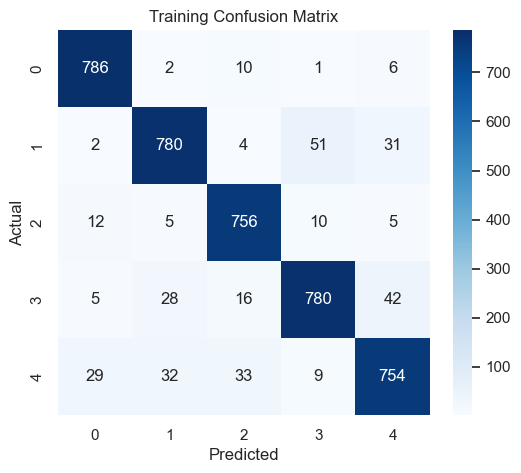

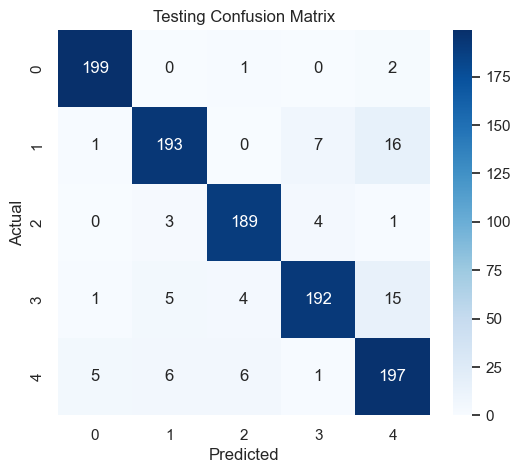

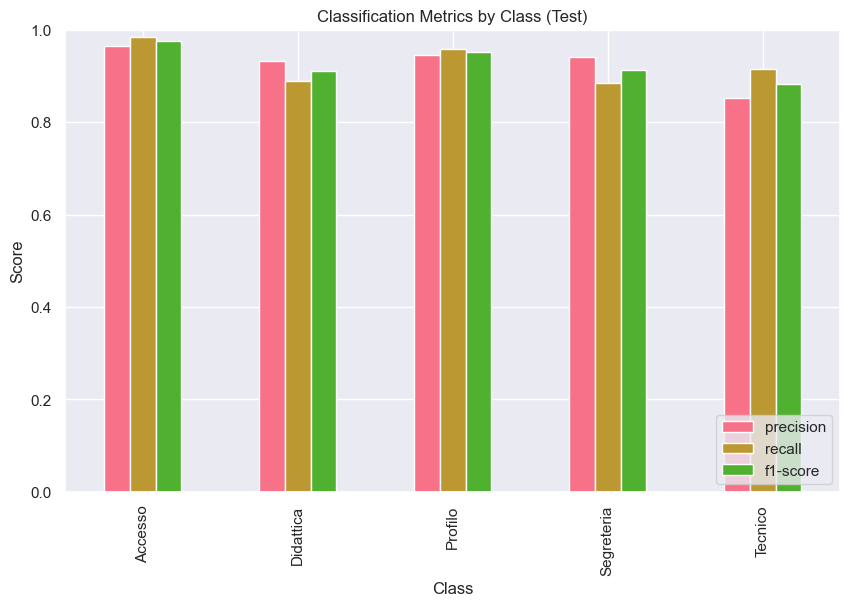

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9229
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.950662  0.980149  0.965180   806.000000
Didattica      0.921893  0.897465  0.909515   868.000000
Profilo        0.927607  0.959391  0.943231   788.000000
Segreteria     0.920991  0.897701  0.909197   870.000000
Tecnico        0.894242  0.886946  0.890579   858.000000
accuracy       0.922912  0.922912  0.922912     0.922912
macro avg      0.923079  0.924331  0.923541  4190.000000
weighted avg   0.922652  0.922912  0.922620  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[790   1   8   1   6]
 [  2 779   3  48  36]
 [ 10   6 756  11   5]
 [  4  26  16 781  43]
 [ 25  33  32   7 761]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9160
[INFO] Classification Report (T

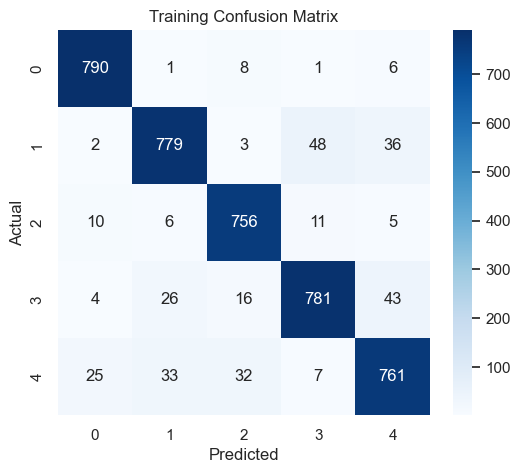

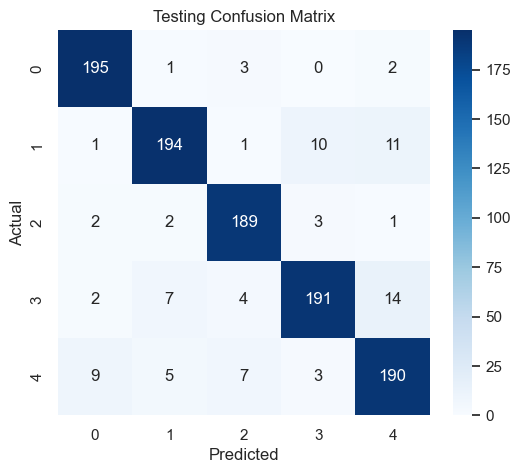

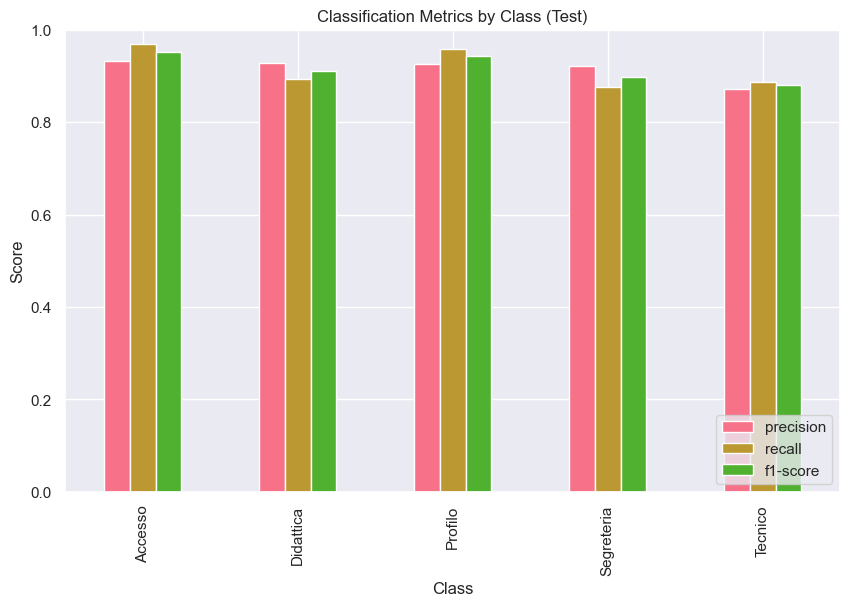

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9193
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.948193  0.976427  0.962103   806.000000
Didattica      0.917062  0.891705  0.904206   868.000000
Profilo        0.934568  0.960660  0.947434   788.000000
Segreteria     0.916865  0.887356  0.901869   870.000000
Tecnico        0.881944  0.888112  0.885017   858.000000
accuracy       0.919332  0.919332  0.919332     0.919332
macro avg      0.919726  0.920852  0.920126  4190.000000
weighted avg   0.919110  0.919332  0.919058  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[787   2   8   1   8]
 [  2 774   3  49  40]
 [  8   8 757  11   4]
 [  5  29  14 772  50]
 [ 28  31  28   9 762]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9303
[INFO] Classification Report (T

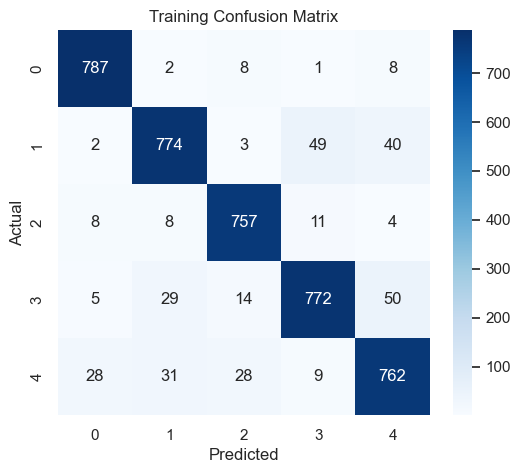

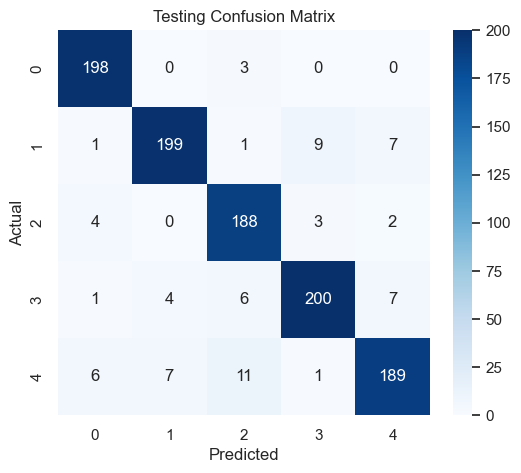

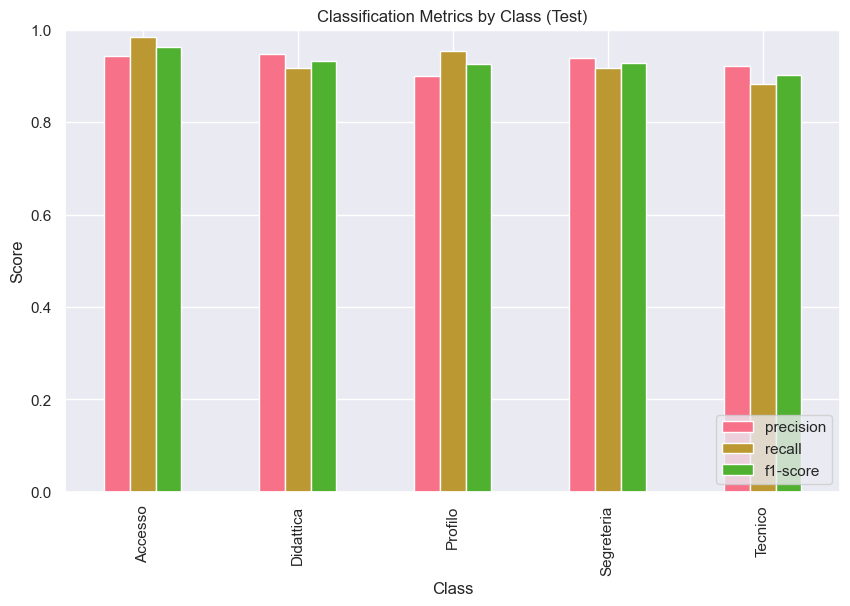

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9212
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.942515  0.976427  0.959171   806.000000
Didattica      0.929426  0.895161  0.911972   868.000000
Profilo        0.924113  0.958122  0.940810   788.000000
Segreteria     0.926278  0.895402  0.910579   870.000000
Tecnico        0.885017  0.888112  0.886562   858.000000
accuracy       0.921241  0.921241  0.921241     0.921241
macro avg      0.921470  0.922645  0.921819  4190.000000
weighted avg   0.921197  0.921241  0.920982  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[787   2  10   0   7]
 [  3 777   4  43  41]
 [ 11   6 755  12   4]
 [  6  22  16 779  47]
 [ 28  29  32   7 762]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9226
[INFO] Classification Report (T

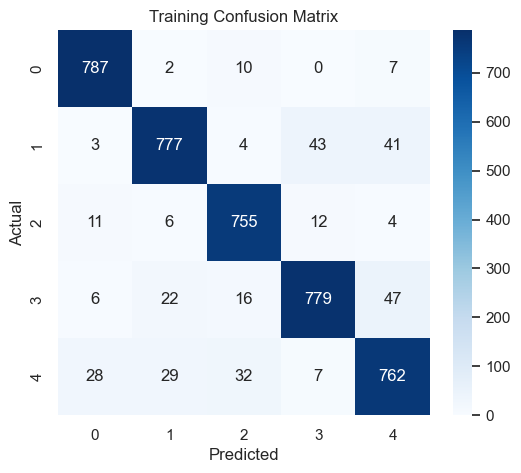

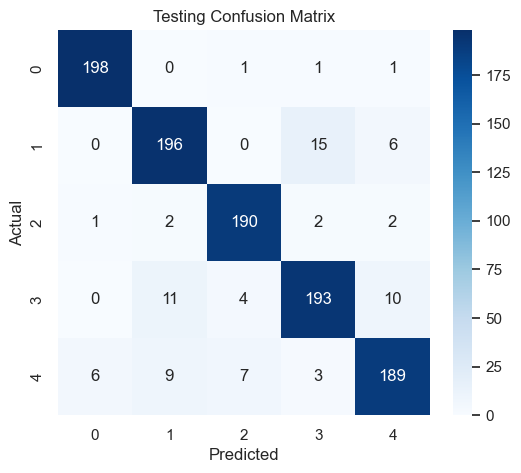

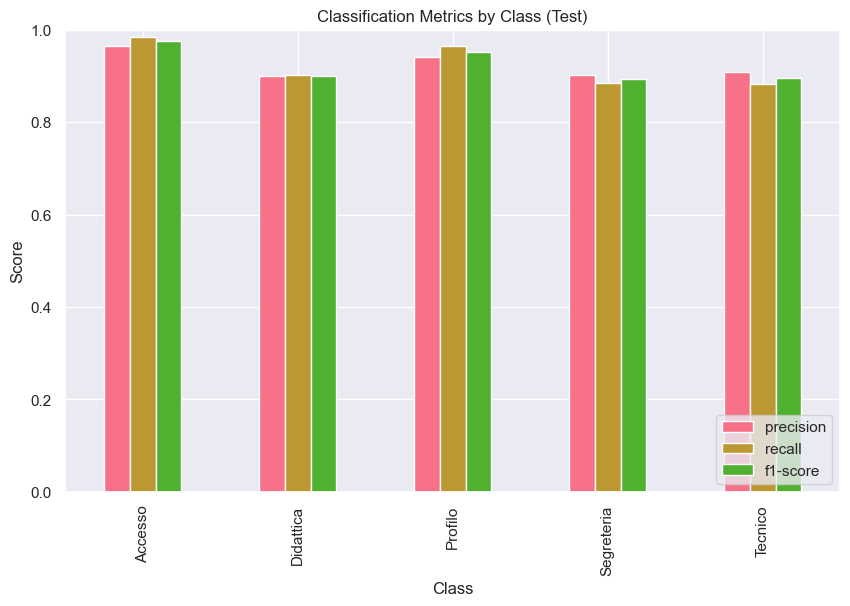

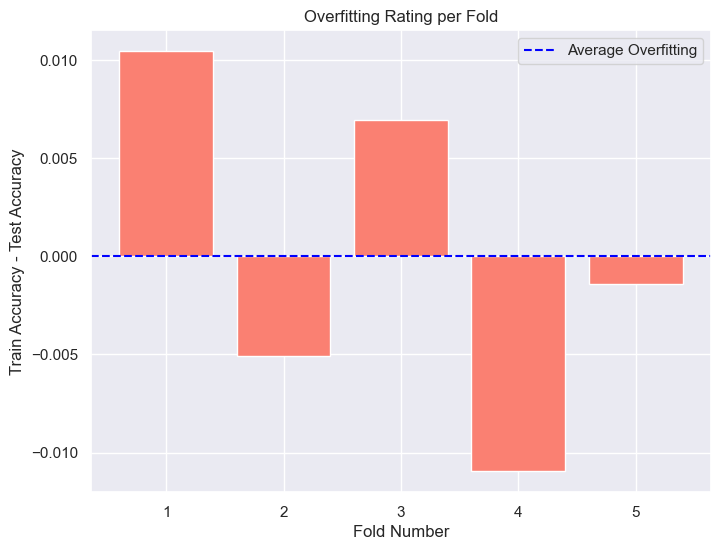

[INFO] Final average evaluation: {'train': {'avg_accuracy': np.float64(0.9215200055150692), 'avg_auc': None, 'avg_confusion_matrix': array([[788. ,   1.6,   8.8,   0.8,   6.4],
       [  2.4, 778.4,   3.2,  46.4,  37.6],
       [  9.6,   6.4, 756. ,  11.2,   4.8],
       [  4.8,  26.4,  16. , 777.6,  45.6],
       [ 27.2,  30.4,  31.2,   8. , 760.8]]), 'avg_classification_report':               precision    recall  f1-score     support
Accesso        0.947125  0.978153  0.962387   805.60000
Didattica      0.923164  0.896774  0.909773   868.00000
Profilo        0.927394  0.959391  0.943118   788.00000
Segreteria     0.921343  0.893382  0.907140   870.40000
Tecnico        0.889687  0.887126  0.888377   857.60000
accuracy       0.921520  0.921520  0.921520     0.92152
macro avg      0.921743  0.922965  0.922159  4189.60000
weighted avg   0.921336  0.921520  0.921235  4189.60000}, 'test': {'avg_accuracy': np.float64(0.9215207754616973), 'avg_auc': None, 'avg_confusion_matrix': array([[197.

{'train': {'avg_accuracy': np.float64(0.9215200055150692), 'avg_auc': None, 'avg_confusion_matrix': array([[788. ,   1.6,   8.8,   0.8,   6.4],
       [  2.4, 778.4,   3.2,  46.4,  37.6],
       [  9.6,   6.4, 756. ,  11.2,   4.8],
       [  4.8,  26.4,  16. , 777.6,  45.6],
       [ 27.2,  30.4,  31.2,   8. , 760.8]]), 'avg_classification_report':               precision    recall  f1-score     support
Accesso        0.947125  0.978153  0.962387   805.60000
Didattica      0.923164  0.896774  0.909773   868.00000
Profilo        0.927394  0.959391  0.943118   788.00000
Segreteria     0.921343  0.893382  0.907140   870.40000
Tecnico        0.889687  0.887126  0.888377   857.60000
accuracy       0.921520  0.921520  0.921520     0.92152
macro avg      0.921743  0.922965  0.922159  4189.60000
weighted avg   0.921336  0.921520  0.921235  4189.60000}, 'test': {'avg_accuracy': np.float64(0.9215207754616973), 'avg_auc': None, 'avg_confusion_matrix': array([[197. ,   0.4,   2.2,   0.2,   1.6],
 

In [46]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
naive_bayes_predictions = ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES)

In [47]:
pd.DataFrame(naive_bayes_predictions, columns=["Class", "Probability"])

,Class,Probability
0,Tecnico,0.757082
1,Accesso,0.086398
2,Profilo,0.056845
